In [1]:
from os import device_encoding
from data import mntDataLoader
import torch.nn as nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import d2l.torch as d2l
from tqdm import tqdm


In [2]:
class Encoder(nn.Module):
  def __init__(self,voc_size,features,hiddens,num_layers=3,num_directions=1,dropout = 0.5) -> None:
    super().__init__()
    self.hiddens = hiddens
    self.num_layers = num_layers
    self.num_directions = num_directions
    self.embedding = nn.Embedding(voc_size,features)   # 这里的voc_size不是输入向量的维度，而是会出现多少个不同的索引将会被映射
    self.rnn = nn.GRU(features,hiddens,num_layers)
    self.dropout = nn.Dropout(dropout)
    self.normLayer = nn.LayerNorm(hiddens)
  
  def forward(self,x):
    '''
    x: (batch_size,nums_step,voc_size)
    '''
    x = self.embedding(x)
    x = x.permute(1,0,2)
    output,state = self.rnn(x)
    state = self.normLayer(self.dropout(state))
    return output,state

class Decoder(nn.Module):
  def __init__(self, voc_size,features,hiddens,num_layers=3,num_directions=1,dropout = 0.5) -> None:
    super().__init__()
    self.embedding = nn.Embedding(voc_size,features)
    self.rnn = nn.GRU(features+hiddens,hiddens,num_layers)
    self.dense = nn.Linear(hiddens,voc_size)
    self.dropout = nn.Dropout(dropout)
    self.normLayer = nn.LayerNorm(hiddens)
  
  def init_state(self,enc_output):
    return enc_output[1]
  def forward(self,x,state,context_and_x=None):
    x = self.embedding(x)
    x = x.permute(1,0,2)   # (time_step,batch_size,features)
    if context_and_x is None:
      context = state[-1].repeat((x.size(0),1,1)) # state(1,batch_size,hidden_size)  取最后一层隐藏状态   
      context_and_x = torch.cat((x,context),-1)   # 广播，让每个时间步有相同的编码器隐藏状态
    output,state = self.rnn(context_and_x,state)  # (time_step,batch_size,hidden_size)
    output = self.normLayer(x+self.dropout(output))
    output = self.dense(output).permute(1,0,2)
    return output,state,context_and_x

class EncoderDecoder(nn.Module):
  def __init__(self, encoder: Encoder,decoder: Decoder) -> None:
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  def forward(self,src,tar):
    '''
    x: (batch_size,num_step)
    '''
    dec_output = self.encoder(src)
    state = self.decoder.init_state(dec_output)
    output,state,_ = self.decoder(tar,state)
    return output,state


In [3]:
class MaskedSoftmaxCELoss(nn.CrossEntropyLoss):
  def __init__(self, device) -> None:
    super().__init__()
    self.device = device
  """带遮蔽的softmax交叉熵损失函数"""
  # pred的形状：(batch_size,num_steps,vocab_size)
  # label的形状：(batch_size,num_steps)
  # valid_len的形状：(batch_size,)
  def forward(self, pred, label, valid_len):
    weights = torch.zeros_like(label,device=self.device)
    weights = self.sequence_mask(weights, valid_len,1)
    self.reduction='none'
    unweighted_loss = super(MaskedSoftmaxCELoss, self).forward(
        pred.permute(0, 2, 1), label)
    weighted_loss = (unweighted_loss * weights).mean(dim=1)
    return weighted_loss
  def sequence_mask(self,weights, valid_len, val=1):
    mask = torch.arange(weights.size(1),device=weights.device)[None,:] < valid_len[:,None]
    weights[mask] = val
    return weights


In [4]:
def train(net,data_iter,lr,num_epoches,tar_voc,device):
  def xavier_init_weights(m):
    if type(m) == nn.Linear:
      nn.init.xavier_normal(m.weight)
    elif type(m) == nn.GRU:
      for param in m._flat_weights_names:
        if 'weight' in param:
          nn.init.xavier_normal(m._parameters[param])
  
  net.apply(xavier_init_weights)
  net.train()
  net = net.to(device)
  loss = MaskedSoftmaxCELoss(device)
  opt = torch.optim.Adam(net.parameters(),lr)
  loss_list = []
  with tqdm(total = num_epoches,desc='模型训练中') as pbar:
    for epoch in range(num_epoches):
      losses = 0
      nums = 0
      for (src,src_valid_len,Y,tar_valid_len) in data_iter:
        opt.zero_grad()
        src = src.to(device)
        Y = Y.to(device)
        tar_valid_len = tar_valid_len.to(device)
        bos = torch.tensor(tar_voc['<bos>'],device=device).repeat((Y.size(0),1))
        tar = Y[:,:-1]
        tar = torch.cat((bos,tar),dim=-1)
        pre,_ = net(src,tar)
        l = loss(pre,Y,tar_valid_len).sum()
        l.backward()
        # if epoch == 200:
        #   print('test_point')
        d2l.grad_clipping(net,1)
        opt.step()
        losses += l.item()
        nums += src.size(0)
      loss_list.append(losses / nums)
      if (epoch+1) % 1 == 0:
        pbar.update(1)
  
  return loss_list


In [52]:
def main():
  file = '../dataset/fra-eng/fra.txt'
  device = 'cuda:0'
  num_steps = 10
  n_samples = 600
  batch_size = 64
  data_iter,voc_src,voc_tar = mntDataLoader(file,batch_size,n_samples,num_steps,True)
  encoder = Encoder(len(voc_src),32,32)
  decoder = Decoder(len(voc_tar),32,32)
  net = EncoderDecoder(encoder,decoder)
  losses = train(net,data_iter,0.004,300,voc_tar,device)

  print(f'最终损失值:{losses[-1]}')
  plt.plot(range(len(losses)),losses,color='blue')
  plt.show()
  torch.save(net.state_dict(),'seq2seq.pth')


/tmp/ipykernel_4984/2520879144.py:8: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m._parameters[param])
/tmp/ipykernel_4984/2520879144.py:4: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  nn.init.xavier_normal(m.weight)
模型训练中: 100%|████████████████████████████████████████████████| 300/300 [00:21<00:00, 14.13it/s]


最终损失值:0.17666852256025928


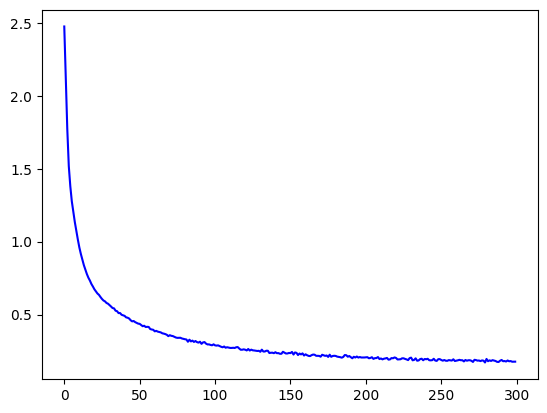

In [53]:
main()

In [54]:
def predict_seq2seq(net, src_sentence, src_vocab, tgt_vocab, num_steps,
                    device, save_attention_weights=False):
    """序列到序列模型的预测"""
    # 在预测时将net设置为评估模式
    net.eval()
    src_tokens = src_vocab[src_sentence.lower().split(' ')] + [
        src_vocab['<eos>']]
    enc_valid_len = torch.tensor([len(src_tokens)], device=device)
    src_tokens = d2l.truncate_pad(src_tokens, num_steps, src_vocab['<pad>'])
    # 添加批量轴
    enc_X = torch.unsqueeze(
        torch.tensor(src_tokens, device=device), dim=0)
    enc_outputs = net.encoder(enc_X)
    dec_state = net.decoder.init_state(enc_outputs)
    # 添加批量轴
    dec_X = torch.unsqueeze(torch.tensor(
        [tgt_vocab['<bos>']], device=device), dim=0)
    output_seq, attention_weight_seq = [], []
    context = None
    for i in range(num_steps):
        '''
        预测方式一：Y, dec_state,context = net.decoder(dec_X, dec_state,context)
        预测方式二：Y, dec_state,context = net.decoder(dec_X, dec_state)  

        预测方式二和模型训练的解码逻辑不通，但是准确率更高
        初步推测，方式二 dec_state 的隐藏状态实际上已经包含了编码器的时间步信息，介于 GRU 能够记忆的时间步更长远 
        '''
        Y, dec_state,context = net.decoder(dec_X, dec_state)   
        # 我们使用具有预测最高可能性的词元，作为解码器在下一时间步的输入
        dec_X = Y.argmax(dim=2)
        pred = dec_X.squeeze(dim=0).type(torch.int32).item()
        # 保存注意力权重（稍后讨论）
        if save_attention_weights:
            attention_weight_seq.append(net.decoder.attention_weights)
        # 一旦序列结束词元被预测，输出序列的生成就完成了
        if pred == tgt_vocab['<eos>']:
            break
        output_seq.append(pred)
    return ' '.join(tgt_vocab.to_tokens(output_seq)), attention_weight_seq


In [55]:
def predict():
    file = '../dataset/fra-eng/fra.txt'
    device = 'cuda:0'
    num_steps = 5
    data_iter,voc_src,voc_tar = mntDataLoader(file,64,600,10,True)
    # print(voc_src.idx_to_token)
    # print(voc_tar.idx_to_token)
    encoder = Encoder(len(voc_src),32,32)
    decoder = Decoder(len(voc_tar),32,32)
    net = EncoderDecoder(encoder,decoder).to(device)
    net.load_state_dict(torch.load('seq2seq.pth'))
    engs = ['Go !', "i lost .", 'he\'s calm .', 'i\'m home .']
    fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
    for eng, fra in zip(engs, fras):
        translation, attention_weight_seq = predict_seq2seq(
            net, eng, voc_src, voc_tar, num_steps, device)
        print(f'{eng} => {translation}')


In [56]:
with torch.no_grad():
    predict()

Go ! => vas-y !
i lost . => j'ai perdu .
he's calm . => il est parti .
i'm home . => je suis chez moi .
